# How to access CMEMS data using Motu REST API

Notes:

- Before accessing data through Motu REST API, correct authentication needs to be established, see
   - https://github.com/clstoulouse/motu/issues/3
   - https://forum.marine.copernicus.eu/discussion/628/motu-rest-api
   
- API documentation: https://github.com/clstoulouse/motu#ClientRESTAPI
   - use "mode=console" as request parameter to download data as byte stream instead of file

## Example requests 

https://nrt.cmems-du.eu/motu-web/Motu?action=describeproduct&service=GLOBAL_ANALYSIS_FORECAST_WAV_001_027-TDS&product=global-analysis-forecast-wav-001-027

https://nrt.cmems-du.eu/motu-web/Motu?action=productdownload&service=GLOBAL_ANALYSIS_FORECAST_WAV_001_027-TDS&product=global-analysis-forecast-wav-001-027&x_lo=1&x_hi=4&y_lo=-2&y_hi=2&t_lo=2021-01-01T00:00:00&t_hi=2021-01-01T03:00:00

## Preparation

In [1]:
import requests

from motu_utils.utils_cas import authenticate_CAS_for_URL
from motu_utils.utils_http import open_url

import xarray as xr

In [2]:
# Set credentials from environment variables
UN_CMEMS = %env UN_CMEMS
PW_CMEMS = %env PW_CMEMS

In [3]:
# Define urls
url_describe_product = 'https://nrt.cmems-du.eu/motu-web/Motu?action=describeproduct&service=GLOBAL_ANALYSIS_FORECAST_WAV_001_027-TDS&product=global-analysis-forecast-wav-001-027'
url_product_download = 'https://nrt.cmems-du.eu/motu-web/Motu?action=productdownload&service=GLOBAL_ANALYSIS_FORECAST_WAV_001_027-TDS&product=global-analysis-forecast-wav-001-027&x_lo=1&x_hi=4&y_lo=-2&y_hi=2&t_lo=2021-01-01T00:00:00&t_hi=2021-01-01T03:00:00&mode=console'

## Using CAS explicitly

In [ ]:
def create_tgt(session, data):
    """
    Create Ticket Granting Ticket (TGT)
    
    Parameters
    ----------
    session: str
        session or request object
    data: bytes object in the format b'username=<username>&password=<password>'
        request data containing authentication credentials
    
    Returns
    ------- 
    TGT as string
    """
      
    response = session.post('https://cmems-cas.cls.fr/cas/v1/tickets', data)
    tgt = response.content    
    tgt = tgt.decode('utf-8')
    
    parser = etree.HTMLParser()
    root = html.fromstring(tgt)
    
    #tree = etree.ElementTree(root)
    #for e in root.iter():
    #    print(tree.getpath(e))
    
    tgt = root.find('.//form').attrib['action'].split('/')[-1]
    
    return tgt

def create_st(session, service_url, tgt):
    """
    Create Service Ticket (ST)
    
    Parameters
    ----------
    session: str 
        session or request object
    service_url: str
        url of the service the ticket is requested for
    tgt: str 
        Ticket Granting Ticket
    
    Returns
    ------- 
    ST as string
    """
    
    # NOTE: the url has to be url-encoded! This is achieved by quote_plus.
    data = 'service={}'.format(quote_plus(service_url)).encode('utf-8')
    response = session.post('https://cmems-cas.cls.fr/cas/v1/tickets' + '/' + tgt, data)
    st = response.content    
    st = st.decode('utf-8')
    
    return st

In [ ]:
# Create authentication request data
data_tgt = 'username={}&password={}'.format(UN_CMEMS, PW_CMEMS).encode('utf-8')

In [ ]:
with requests.Session() as session:
    
    # Create TGT
    tgt = create_tgt(session, data_tgt)
    
    # Set session cookie
    #auth_cookies = {
    #    "tgt": tgt
    #}
    #cookie_args = {
    #    'secure': True,
    #    'httponly', True,
    #}
    #session.cookies.set(**auth_cookies, **cookie_args)

    # Describe Product
    st = create_st(session, url_describe_product, tgt)  # create service ticket
    response = session.get(url_describe_product + '&ticket=' + st)
    print(response.text)

## Using CAS implicitly via motu-client library

In [4]:
# Get download url with ticket for authentication
download_url = authenticate_CAS_for_URL(url_product_download, UN_CMEMS, PW_CMEMS)

# download_url is the original url appended with an additional request parameter "ticket"
# after one call to the download_url the ticket seems to expire

In [5]:
# Make request
response = open_url(download_url) # type http.client.HTTPResponse
bytes = response.read()           # type bytes

In [6]:
# Store data as xarray
array = xr.open_dataset(bytes)
array

<xarray.Dataset>
Dimensions:    (latitude: 49, longitude: 37, time: 2)
Coordinates:
  * latitude   (latitude) float64 -2.0 -1.917 -1.833 -1.75 ... 1.833 1.917 2.0
  * time       (time) datetime64[ns] 2021-01-01 2021-01-01T03:00:00
  * longitude  (longitude) float64 1.0 1.083 1.167 1.25 ... 3.75 3.833 3.917 4.0
Data variables:
    VHM0_WW    (time, latitude, longitude) float32 ...
    VMDR_SW2   (time, latitude, longitude) float32 ...
    VMDR_SW1   (time, latitude, longitude) float32 ...
    VMDR       (time, latitude, longitude) float32 ...
    VTM10      (time, latitude, longitude) float32 ...
    VTPK       (time, latitude, longitude) float32 ...
    VPED       (time, latitude, longitude) float32 ...
    VTM02      (time, latitude, longitude) float32 ...
    VMDR_WW    (time, latitude, longitude) float32 ...
    VTM01_SW2  (time, latitude, longitude) float32 ...
    VHM0_SW1   (time, latitude, longitude) float32 ...
    VTM01_SW1  (time, latitude, longitude) float32 ...
    VSDX       (time, latitude, longitude) float32 ...
    VSDY       (time, latitude, longitude) float32 ...
    VHM0       (time, latitude, longitude) float32 ...
    VTM01_WW   (time, latitude, longitude) float32 ...
    VHM0_SW2   (time, latitude, longitude) float32 ...
Attributes:
    Conventions:                               CF-1.6
    time_coverage_start:                       20210212-03:00:00
    time_coverage_end:                         20210213-00:00:00
    date_created:                              20210203-07:38:00
    product_type:                              forecast
    product:                                   GLOBAL_ANALYSIS_FORECAST_WAV_0...
    product_ref_date:                          20210203-00:00:00
    product_range:                             D+9
    product_user_manual:                       http://marine.copernicus.eu/do...
    quality_information_document:               http://marine.copernicus.eu/d...
    dataset:                                   global-analysis-forecast-wav-0...
    title:                                     Mean fields from global wave m...
    institution:                               METEO-FRANCE
    references:                                http://marine.copernicus.eu
    credit:                                    E.U. Copernicus Marine Service...
    licence:                                   http://marine.copernicus.eu/se...
    contact:                                   servicedesk.cmems@mercator-oce...
    producer:                                  CMEMS - Global Monitoring and ...
    area:                                      GLO
    FROM_ORIGINAL_FILE__geospatial_lon_min:    -180.0
    FROM_ORIGINAL_FILE__geospatial_lon_max:    179.9167
    FROM_ORIGINAL_FILE__geospatial_lon_step:   0.08332825
    FROM_ORIGINAL_FILE__geospatial_lon_units:  degree
    FROM_ORIGINAL_FILE__geospatial_lat_min:    -80.0
    FROM_ORIGINAL_FILE__geospatial_lat_max:    90.0
    FROM_ORIGINAL_FILE__geospatial_lat_step:   0.08333588
    FROM_ORIGINAL_FILE__geospatial_lat_units:  degree
    _CoordSysBuilder:                          ucar.nc2.dataset.conv.CF1Conve...
    comment:                                   
    source:                                     
    history:                                   Data extracted from dataset ht...

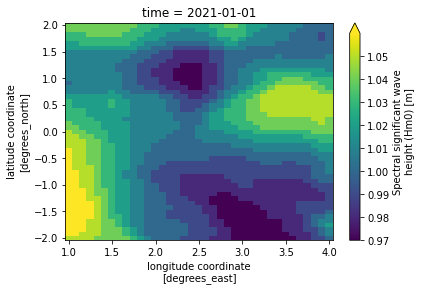

In [7]:
array.VHM0.isel(time=0).plot(robust=True);